###### Inicialização

In [66]:
!pip install meteostat yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [67]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from datetime import datetime, date
from IPython.display import Markdown

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

import seaborn as sns
import plotly.graph_objects as go

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [68]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [69]:
def resultado_teste(stat, p):
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (stat, p)))
  # interpretando resultados
  alpha = 0.05
  if p > alpha:
      display(Markdown("**A amostra parece Gaussiana (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A amostra não parece Gaussiana (rejeitamos H0)**'))

# Análise de Séries temporais (Sessão 7)
---
Pré-processamento (parte 4)


## Filtragem





Estimar explicitamente tendências ($T_t$) e efeitos sazonais ($S_t$) para o cálculo da sequência de variáveis aleatórias:

\begin{align}
X_t= T_t + S_t + R_t \\
R_t= X_t - (T_t + S_t)
\end{align}

#### Construindo os dados sintétios

In [81]:
x = np.arange(1, 100, 0.1)
T = pd.Series(np.log(x))
S = pd.Series(np.sin(x))

mu = 0
sigma = .2
R =  pd.Series(np.random.randn(len(x)) * sigma + mu)

X = T + S + R

In [90]:
d = int(2*np.pi*10 + 1)
q = d // 2
X__ = X.to_frame()
X__.columns = ["X"]

for i in range(q):
  X__[f"X_lag{i+1}"] = X__["X"].shift(-(i+1-q)) if i != (q-1) else X__["X"].shift(-(i+1-q))/2
  X__[f"X_lead{i+1}"] = X__["X"].shift((i+1-q)) if i != (q-1) else X__["X"].shift((i+1-q))/2

X__[f"mm{d}"] = X__.sum(axis=1) / (d)
X__ = X__.iloc[q:]
X__ = X__.iloc[:-q]

#### Obtendo os dados reais

In [72]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

In [73]:
d2 = 365
q2 = d2 // 2
sa__ = serie_aracaju.tavg.to_frame()
sa__.columns = ["X"]

for i in range(q2):
  sa__[f"X_lag{i+1}"] = sa__["X"].shift(-(i+1-q2)) if i != (q2-1) else sa__["X"].shift(-(i+1-q2))/2
  sa__[f"X_lead{i+1}"] = sa__["X"].shift((i+1-q2)) if i != (q2-1) else sa__["X"].shift((i+1-q2))/2

sa__[f"mm{d2}"] = sa__.sum(axis=1) / d2
sa__ = sa__.iloc[q2:]
sa__ = sa__.iloc[:-q2]

In [74]:
serie_dolar = pdr.get_data_yahoo("USDBRL=X", start="2007-01-01", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


### Filtragem do Efeito Sazonal

Para uma decomposição total de uma série temporal periódica, é necessário estimar o efeito sazonal, da seguinte forma

\begin{align}
S_{dez} = S_{12} = S_{24} = \frac{1}{N} \sum_{j=0}^{N-1}{(X_{12j+12} - T_{12j+12})}
\end{align} 

onde N é a quantidade de repetições do ciclo (anos, meses, dias, ...)

#### Aplicando nos dados sintéticos

In [75]:
N = len(x) // (2*np.pi*10)
N

15.0

In [91]:
X__["sazonal"] = X__.index % d

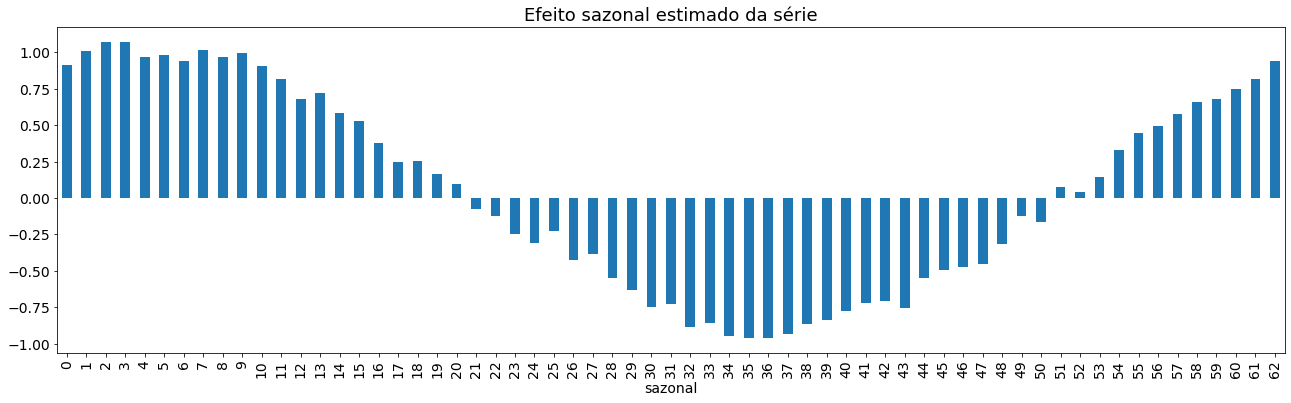

In [92]:
sazonal = X__.groupby("sazonal")[["X", f"mm{d}"]].sum()
sazonal["efeito"] = (sazonal["X"] - sazonal[f"mm{d}"]) / N

_ = sazonal["efeito"].plot(kind='bar', title = "Efeito sazonal estimado da série")

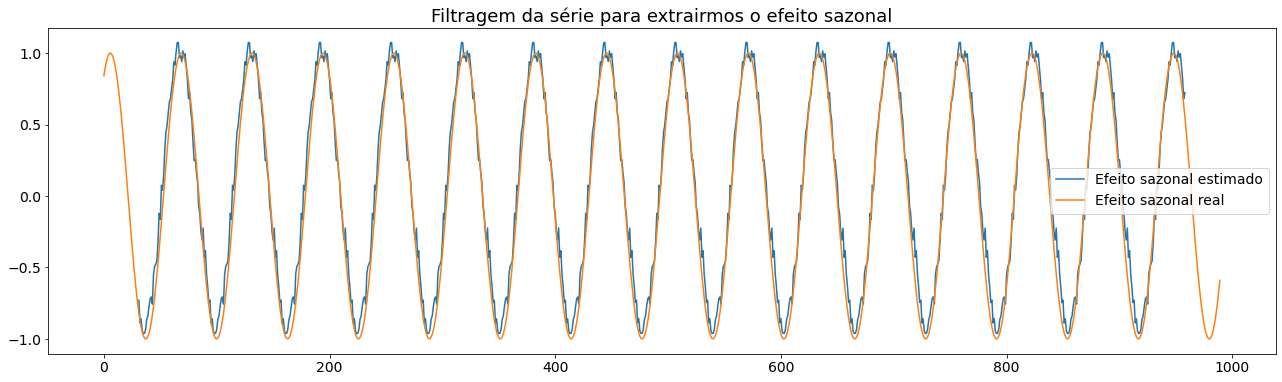

In [93]:
X__["efeito_sazonal"] = X__["sazonal"].map(sazonal["efeito"]) #Aplicando o efeito sazonal estimado em toda a série 

ax = X__["efeito_sazonal"].plot(title="Filtragem da série para extrairmos o efeito sazonal", label="Efeito sazonal estimado", legend= True)
_ = S.plot(ax=ax, label="Efeito sazonal real", legend= True)

#### Aplicando nos dados reais

In [94]:
sa__["Dia"] = sa__.index.day_of_year
sa__["Semana"] = sa__.index.isocalendar().week
sa__["Mês"] = sa__.index.month

In [95]:
anos = len(set(sa__.index.year))
anos

5

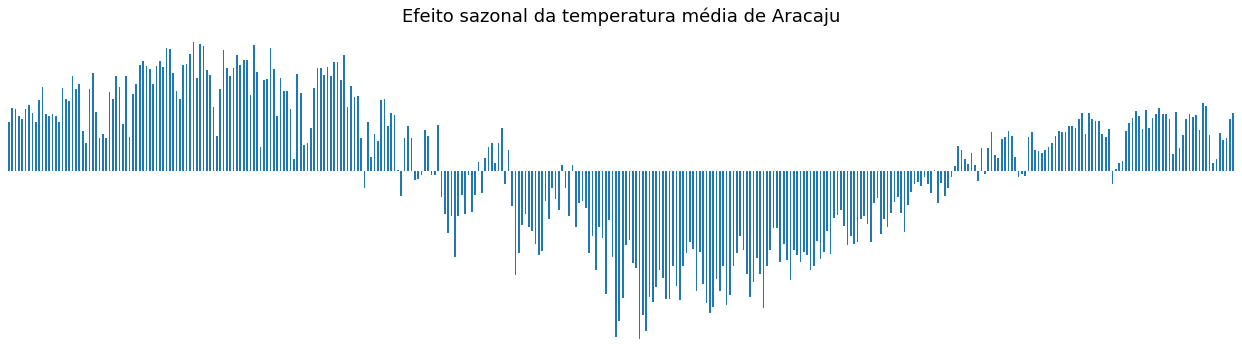

In [96]:
sazonal_aracaju = sa__.groupby("Dia")[["X", f"mm{d2}"]].mean()
sazonal_aracaju["efeito"] = (sazonal_aracaju["X"] - sazonal_aracaju[f"mm{d2}"])

_ = sazonal_aracaju["efeito"].plot(kind='bar', title = "Efeito sazonal da temperatura média de Aracaju").axis('off')

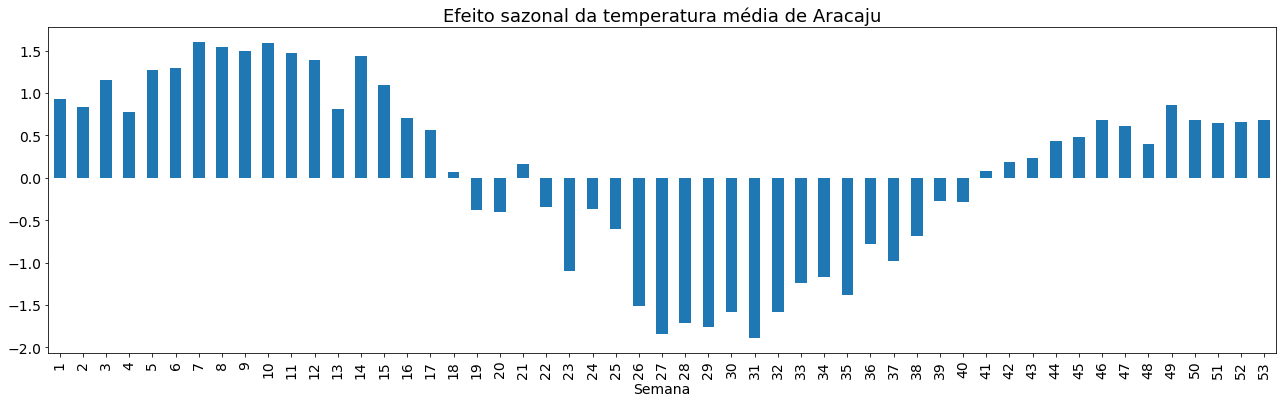

In [97]:
sazonal_aracaju = sa__.groupby("Semana")[["X", f"mm{d2}"]].mean()
sazonal_aracaju["efeito"] = (sazonal_aracaju["X"] - sazonal_aracaju[f"mm{d2}"])

_ = sazonal_aracaju["efeito"].plot(kind='bar', title = "Efeito sazonal da temperatura média de Aracaju")

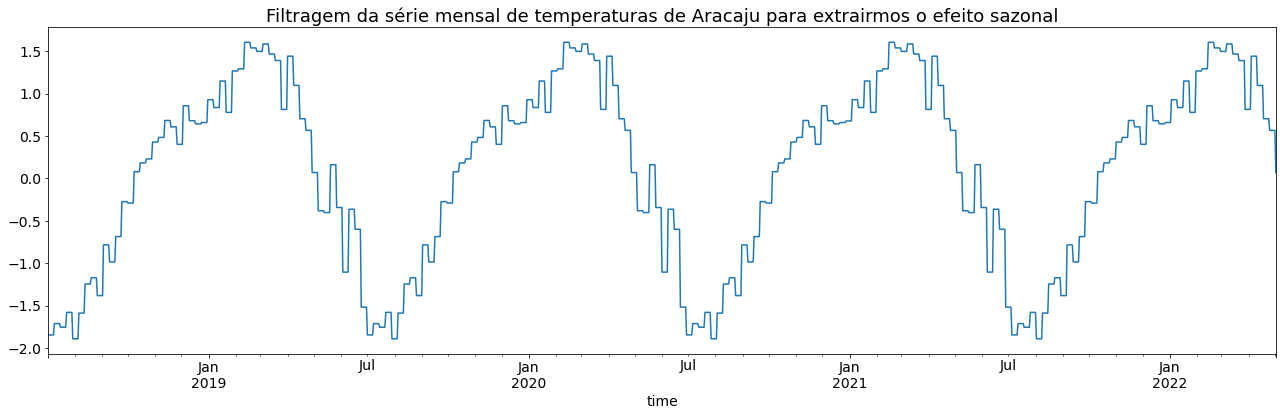

In [98]:
sa__["efeito_sazonal"] = sa__["Semana"].map(sazonal_aracaju["efeito"]) #Aplicando o efeito sazonal estimado em toda a série 

_ = sa__["efeito_sazonal"].plot(title="Filtragem da série mensal de temperaturas de Aracaju para extrairmos o efeito sazonal")

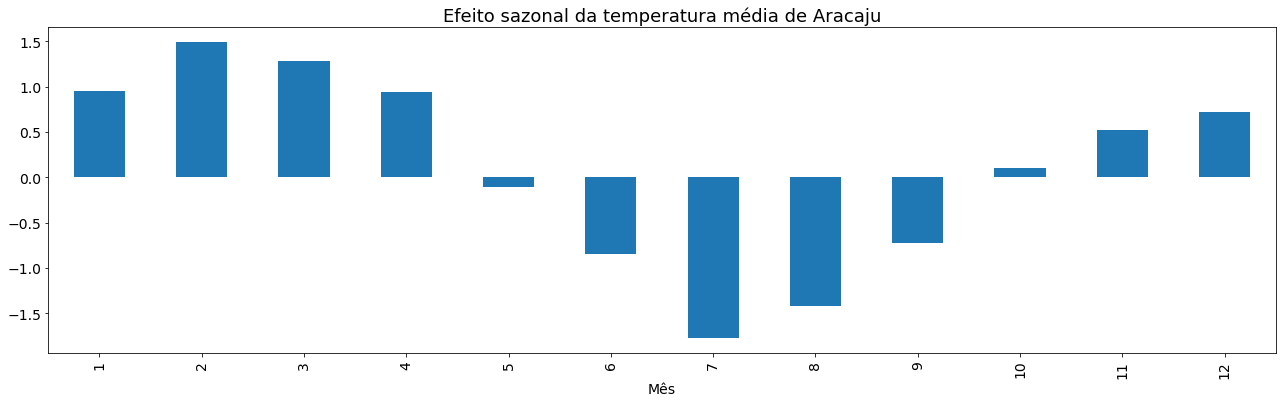

In [99]:
sazonal_aracaju = sa__.groupby("Mês")[["X", f"mm{d2}"]].mean()
sazonal_aracaju["efeito"] = (sazonal_aracaju["X"] - sazonal_aracaju[f"mm{d2}"])

_ = sazonal_aracaju["efeito"].plot(kind='bar', title = "Efeito sazonal da temperatura média de Aracaju")

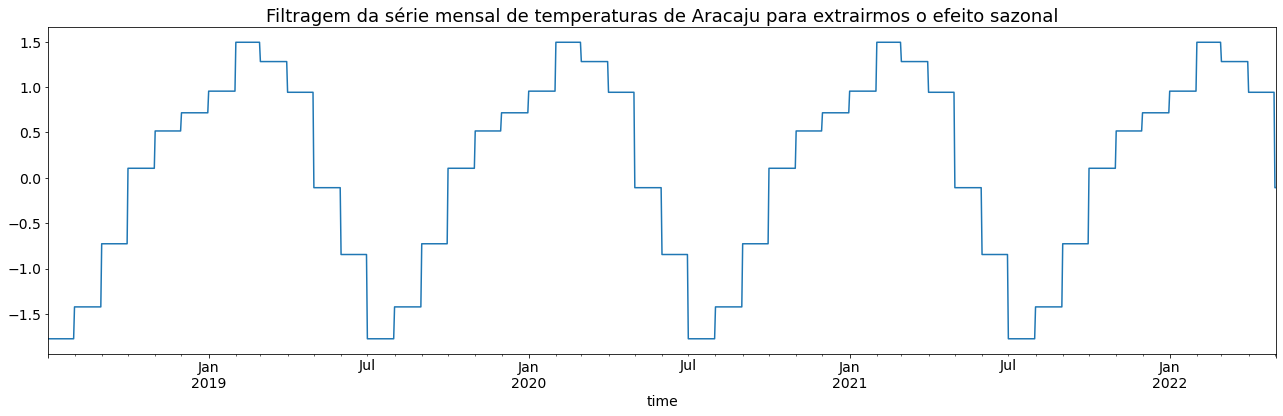

In [100]:
sa__["efeito_sazonal"] = sa__["Mês"].map(sazonal_aracaju["efeito"]) #Aplicando o efeito sazonal estimado em toda a série 

_ = sa__["efeito_sazonal"].plot(title="Filtragem da série mensal de temperaturas de Aracaju para extrairmos o efeito sazonal")

###### Exemplo de aplicações:
1. Vendas por famílias de produto
2. Produção de uma fábrica
3. Contratações de crédito por grupos setoriais empresariais (agricultura, indústria, varejistas, ...) 

### Filtragem do Resíduo


\begin{align}
X_t= T_t + S_t + R_t \\
R_t= X_t - (T_t + S_t)
\end{align}

#### Aplicando nos dados sintéticos

In [101]:
X__["resíduo"] = X__["X"] - (X__[f"mm{d}"] + X__["efeito_sazonal"])

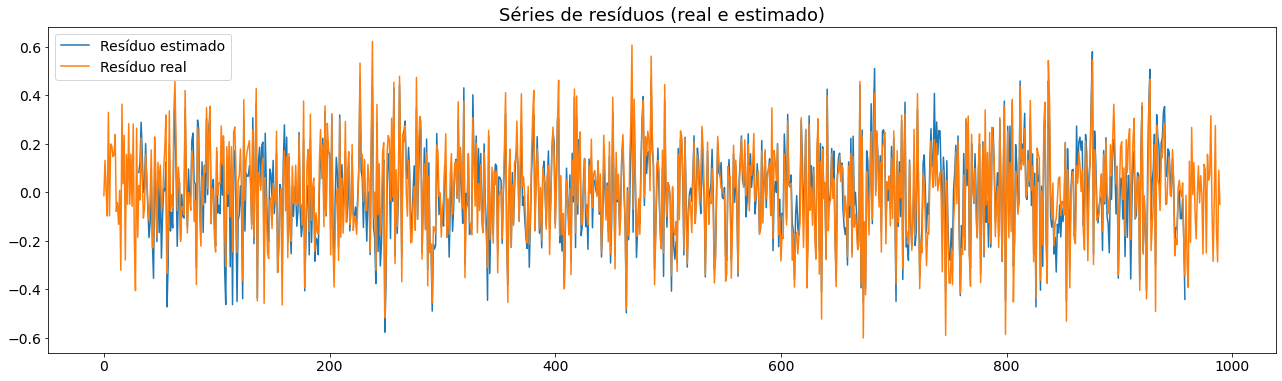

In [102]:
ax = X__["resíduo"].plot(title= "Séries de resíduos (real e estimado)", label="Resíduo estimado", legend= True)
_ = R.plot(ax=ax, label="Resíduo real", legend= True)

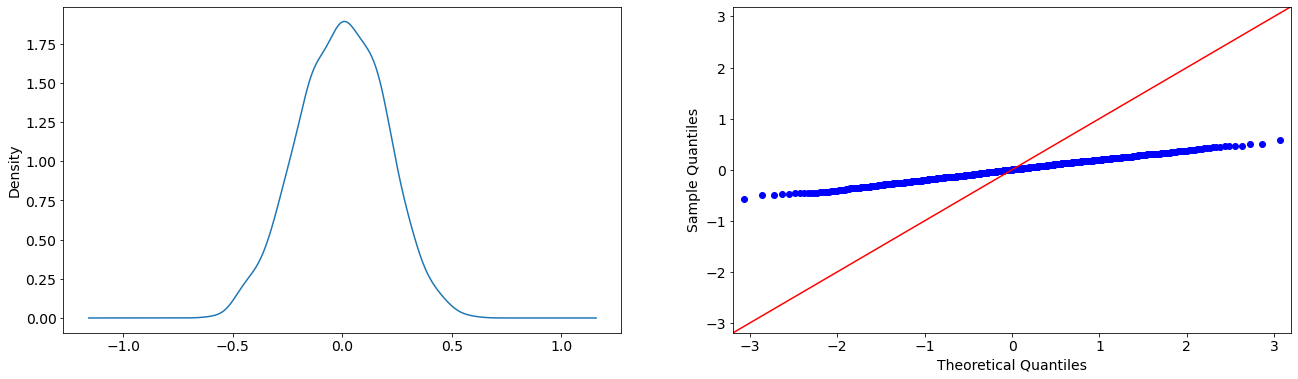

In [103]:
fig, axs = plt.subplots(1,2)
_ = X__["resíduo"].plot(kind="kde", ax=axs[0])
sm.qqplot(X__["resíduo"], line ='45', ax=axs[1])
plt.show()

In [104]:
stat, p = stats.shapiro(X__["resíduo"])

resultado_teste(stat, p)

Statistics=0.998, p-valor=0.21196720

**A amostra parece Gaussiana (falhamos em rejeitar H0)**

#### Aplicando nos dados reais

In [105]:
sa__["resíduo"] = sa__["X"] - (sa__[f"mm{d2}"] + sa__["efeito_sazonal"])

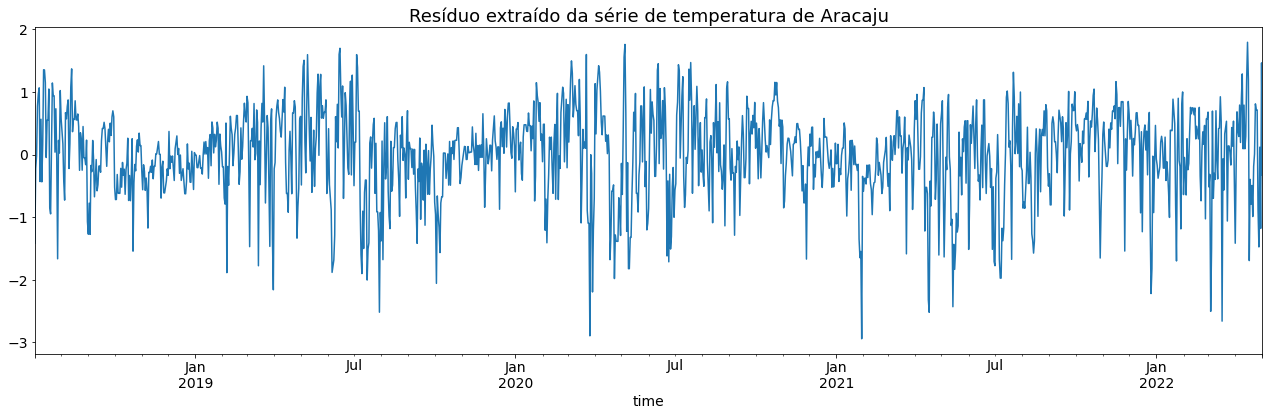

In [106]:
_ = sa__["resíduo"].plot(title= "Resíduo extraído da série de temperatura de Aracaju")

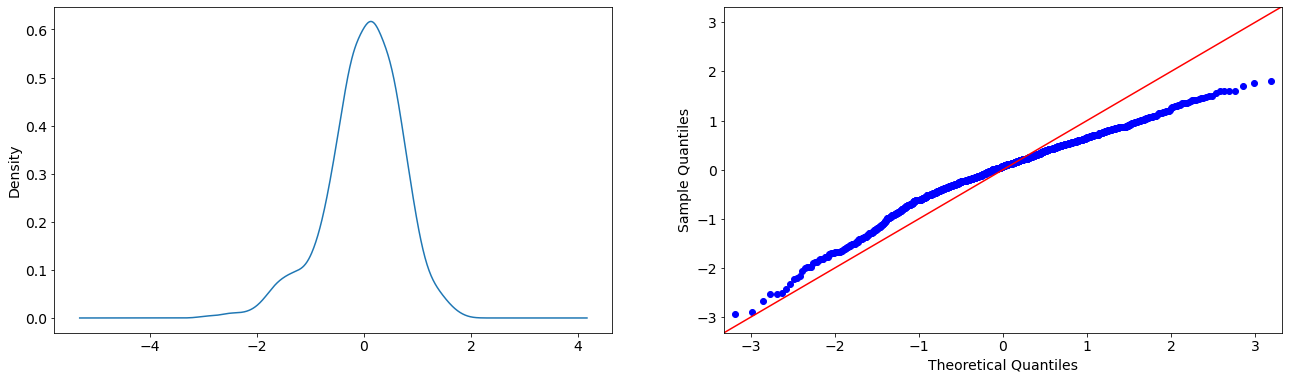

In [107]:
fig, axs = plt.subplots(1,2)
_ = sa__["resíduo"].plot(kind="kde", ax=axs[0])
sm.qqplot(sa__["resíduo"], line ='45', ax=axs[1])
plt.show()

In [108]:
stat, p = stats.shapiro(sa__["resíduo"])

resultado_teste(stat, p)

Statistics=0.973, p-valor=0.00000000

**A amostra não parece Gaussiana (rejeitamos H0)**

## Exercício

1. Qual o tendência extraída de uma filtragem da série da temperatura média da cidade de Porto Alegre, quando analisamos a série de 2018 a 2022?
2. Qual o o efeito sazonal da temperatura média da cidade de Porto Alegre, quando analisamos a série de 2018 a 2022?
3. Qual o tendência extraída de uma filtragem da série da temperatura média intradiária (a cada hora do dia) da cidade de Porto Alegre, se analisarmos apenas os meses de janeiro a julho de 2020?